<a href="https://colab.research.google.com/github/Mateus-Maciel/projetos-1-/blob/main/GettChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import os

# --- Carregamento de Dados no Google Colab ---

# Use o caminho copiado da barra lateral do Colab.
# É provável que seja '/content/nome_do_arquivo.csv'
orders_filepath = '/content/data_orders.csv'
offers_filepath = '/content/data_offers.csv'

try:
    df_orders = pd.read_csv(orders_filepath)
    df_offers = pd.read_csv(offers_filepath)
    print("Sucesso! Os arquivos foram carregados a partir do caminho específico do Colab.")

    # --- A partir daqui, executamos a Fase 1 que já planejamos ---

    print("\n--- Análise do DataFrame 'data_orders' ---")
    df_orders.info()

    print("\n--- Contagem de Nulos (df_orders) ---")
    print(df_orders.isnull().sum())

    print("\n--- Análise do DataFrame 'data_offers' ---")
    df_offers.info()

    print("\n--- Contagem de Nulos (df_offers) ---")
    print(df_offers.isnull().sum())

except FileNotFoundError:
    print("\nERRO: O caminho do arquivo está incorreto.")
    print(f"Verifiquei o caminho '{orders_filepath}' e '{offers_filepath}'.")
    print("Certifique-se de que correspondem EXATAMENTE ao caminho copiado do painel de arquivos do Colab.")

Sucesso! Os arquivos foram carregados a partir do caminho específico do Colab.

--- Análise do DataFrame 'data_orders' ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB

--- Contagem de Nulos (df_orders) ---
order_datetime                      0
origin_longitude            

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

df_orders = pd.read_csv(orders_filepath)

#Extrair a hora da coluna "order_datetime"
df_orders['order_hour'] = pd.to_datetime(df_orders["order_datetime"]).dt.hour

#Criando coluna "failure_reason" (lógica de negócio)

def assign_failure_reason(row):
  if row["order_status_key"] == 4 and row["is_driver_assigned_key"] == 0:
    return "Cancelado pelo Cliente (Sem Motorista)"
  elif row["order_status_key"] == 4 and row["is_driver_assigned_key"] == 1:
    return "Cancelado pelo Cliente (Com Motorista)"
  elif row["order_status_key"]== 9:
    return "Rejeitado pelo Sistema"
  else:
    return "Outro" #Bom para casos inesperados.

df_orders["failure_reason"] = df_orders.apply(assign_failure_reason, axis=1)

print("Coluna 'failure_readon' criada com sucesso. Verificando a distribuição:")
print(df_orders["failure_reason"].value_counts())

#Verificando as hipóteses sobre valores nulos

print("\n--- Verificação de Hipóteses sobre valores nulos ---")
eta_null_by_driver_assigned = df_orders.groupby("is_driver_assigned_key")['m_order_eta'].apply(lambda x: x.isnull().sum() / len(x) * 100)
print("\nPercentual de ETA nulo por status de atribuição")
print(eta_null_by_driver_assigned)

cancellation_time_null_by_status = df_orders.groupby("order_status_key")["cancellations_time_in_seconds"].apply(lambda x: x.isnull().sum() / len(x) * 100)
print("\nPercentual de 'cancellation_time' nulo por status da ordem:")
print(cancellation_time_null_by_status)

# Salvando o dataframe processado

df_orders.to_csv('data_orders_processed.csv', index=False)



/tmp/ipython-input-1133088133.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orders['order_hour'] = pd.to_datetime(df_orders["order_datetime"]).dt.hour


Coluna 'failure_readon' criada com sucesso. Verificando a distribuição:
failure_reason
Cancelado pelo Cliente (Sem Motorista)    4496
Rejeitado pelo Sistema                    3409
Cancelado pelo Cliente (Com Motorista)    2811
Name: count, dtype: int64

--- Verificação de Hipóteses sobre valores nulos ---

Percentual de ETA nulo por status de atribuição
is_driver_assigned_key
0    100.0
1      0.0
Name: m_order_eta, dtype: float64

Percentual de 'cancellation_time' nulo por status da ordem:
order_status_key
4      0.0
9    100.0
Name: cancellations_time_in_seconds, dtype: float64


/tmp/ipython-input-1249002206.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(



Gráfico 'failure_reason_distribution.png' salvo com sucesso!


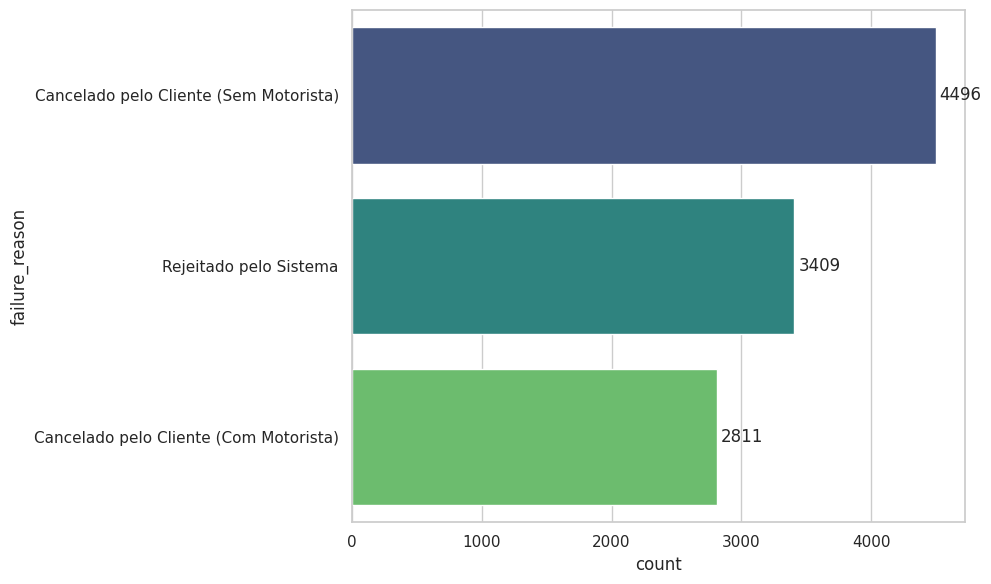

In [40]:
# Configurando o gráfico

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Criando o gráfico de contagem orgenado

order_by_count = df_orders["failure_reason"].value_counts().index
ax = sns.countplot(
    y="failure_reason",
    data=df_orders,
    order=order_by_count,
    palette="viridis"
)

# Adicionando o valor exato em cada barra

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

# Otimizar o layout e salvar o gráfico

plt.tight_layout()
plt.savefig('failure_reason_count.png')

print("\nGráfico 'failure_reason_distribution.png' salvo com sucesso!")

Gráfico 'failure_reason_by_hour.png' salvo com sucesso!

A hora com o maior número total de falhas é 8:00, com 1082 falhas.


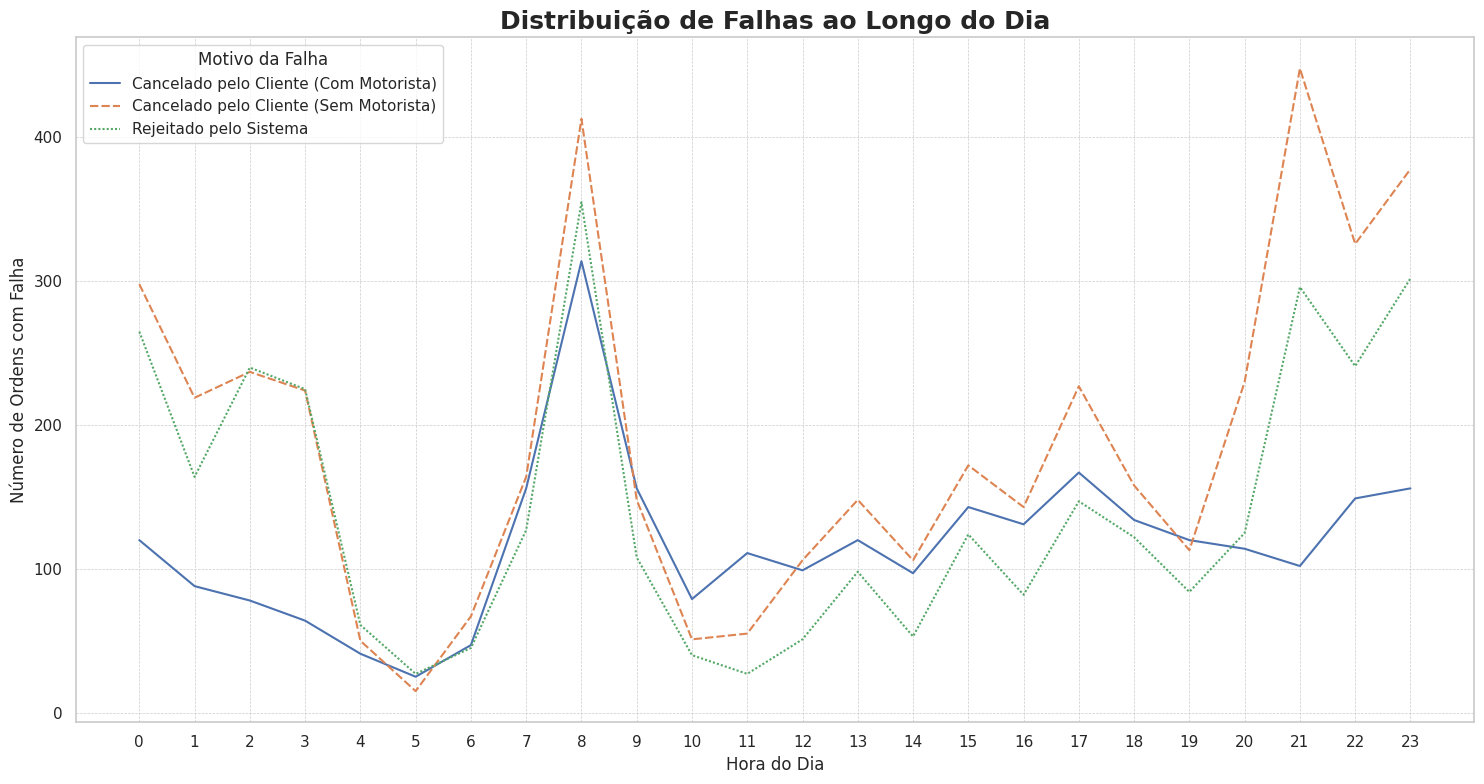

In [41]:
# Agrupando os dados por hora e motiva da falha

fails_by_hour = df_orders.groupby(["order_hour", "failure_reason"]).size().unstack(fill_value=0)

# Criando o gráfico de linhas

plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")

# Plotando as linhas
ax = sns.lineplot(data=fails_by_hour)


# Adicionando títulos e rótulos

ax.set_title("Distribuição de Falhas ao Longo do Dia", fontsize=18,weight="bold")
ax.set_xlabel("Hora do Dia", fontsize=12)
ax.set_ylabel("Número de Ordens com Falha", fontsize=12)
ax.legend(title="Motivo da Falha")
ax.grid(True, which="both", linestyle='--', linewidth=0.5)
ax.set_xticks(range(0,24)) #Mostra todas as horas

# Otimizar o layout e salvar

plt.tight_layout()
plt.savefig('failure_reason_by_hour.png')

print("Gráfico 'failure_reason_by_hour.png' salvo com sucesso!")

#Identificando o horário de pico geral

total_fails_per_hour = df_orders.groupby("order_hour").size()
peak_hour = total_fails_per_hour.idxmax()
peak_value = total_fails_per_hour.max()


print(f"\nA hora com o maior número total de falhas é {peak_hour}:00, com {peak_value} falhas.")

Número original de cancelamentos de clientes: 7307
Número de cancelamentos de clientes após remover outliers: 6715
Removidos 592 outliers.

Gráfico 'cancellation_time_by_hour.png' salvo com sucesso!


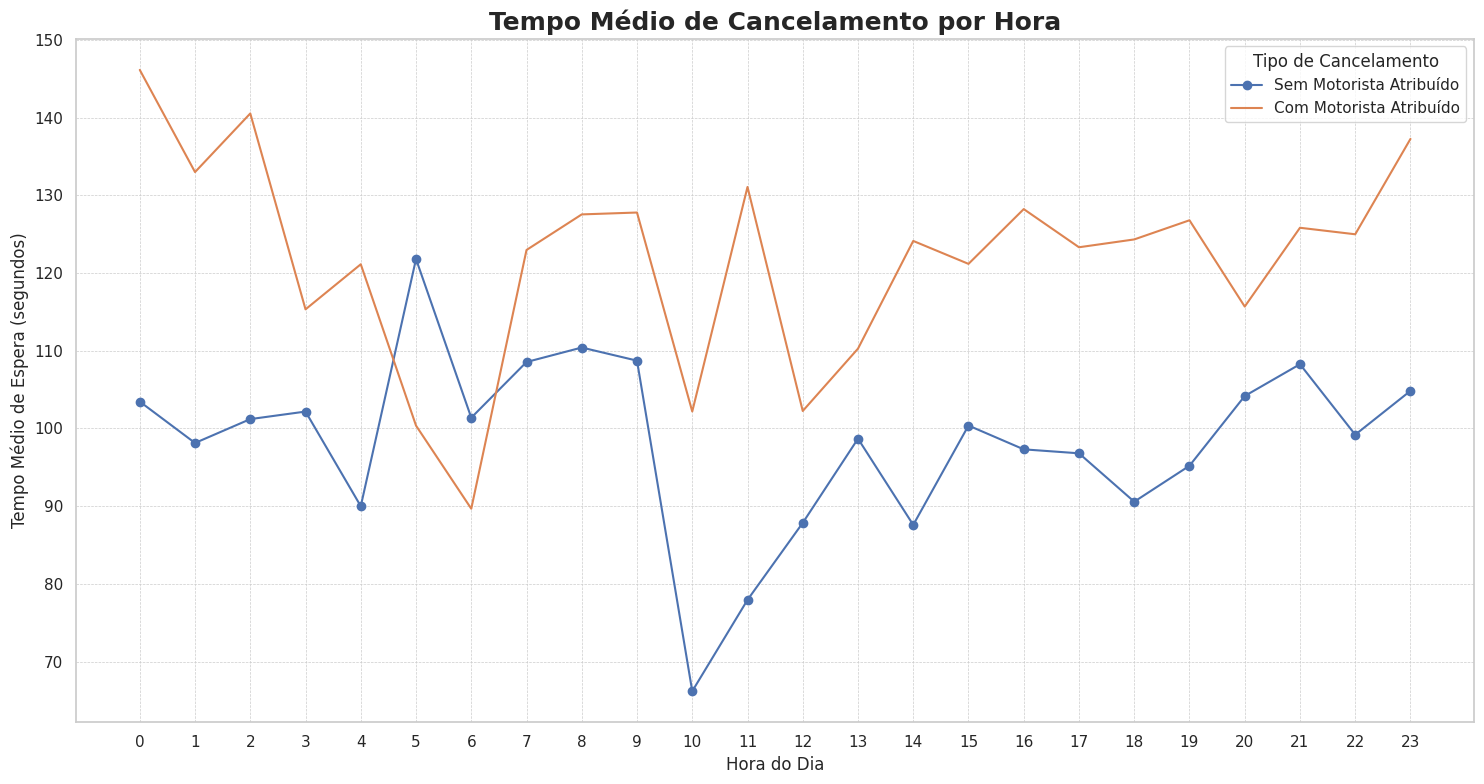

In [42]:
# Filtrando através dos cancelamentos de clientes (tem o tempo registrado)

client_cancellations = df_orders[df_orders["order_status_key"] == 4].copy()

# Removendo os outliers de "cancellations_time_in_seconds, usando o método IQR"

Q1 = client_cancellations["cancellations_time_in_seconds"].quantile(0.25)
Q3 = client_cancellations["cancellations_time_in_seconds"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Vamos manter os dados dentro dos limites.

cancellations_no_outliers = client_cancellations[
    (client_cancellations["cancellations_time_in_seconds"] >= lower_bound) &
    (client_cancellations["cancellations_time_in_seconds"] <= upper_bound)
    ]

print(f"Número original de cancelamentos de clientes: {len(client_cancellations)}")
print(f"Número de cancelamentos de clientes após remover outliers: {len(cancellations_no_outliers)}")
print(f"Removidos {len(client_cancellations) - len(cancellations_no_outliers)} outliers.")

#Separando os dados em "com motorista e sem motorista"
no_driver = cancellations_no_outliers[cancellations_no_outliers["is_driver_assigned_key"] == 0]
with_driver = cancellations_no_outliers[cancellations_no_outliers["is_driver_assigned_key"] == 1]

# Calculando a média do tempo de cancelamento por hora para cada grupo

avg_time_no_driver = no_driver.groupby("order_hour")["cancellations_time_in_seconds"].mean()
avg_time_with_driver = with_driver.groupby("order_hour")["cancellations_time_in_seconds"].mean()

plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")

plt.plot(avg_time_no_driver.index, avg_time_no_driver.values, marker="o", linestyle="-", label="Sem Motorista Atribuído")
plt.plot(avg_time_with_driver.index, avg_time_with_driver.values, label="Com Motorista Atribuído")

#Adicionando títulos e rótulos

plt.title("Tempo Médio de Cancelamento por Hora", fontsize=18, weight="bold")
plt.xlabel("Hora do Dia", fontsize=12)
plt.ylabel("Tempo Médio de Espera (segundos)", fontsize=12)
plt.xticks(range(0,24))
plt.legend(title="Tipo de Cancelamento")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Otimizando e Salvando

plt.tight_layout()
plt.savefig('cancellation_time_by_hour.png')

print("\nGráfico 'cancellation_time_by_hour.png' salvo com sucesso!")

In [43]:
# Criando um DataFrame para comparar os resultados lado a lado
df_comparison = pd.DataFrame({
    'Sem_Motorista_Avg_Secs': avg_time_no_driver,
    'Com_Motorista_Avg_Secs': avg_time_with_driver
})

# Preenchendo horas faltantes (se houver) com 0 para uma visualização completa
df_comparison = df_comparison.reindex(range(0, 24), fill_value=0).round(1)


print("--- Dados do Gráfico: Tempo Médio de Cancelamento (em segundos) ---")
print(df_comparison)


# Vamos também calcular algumas estatísticas gerais importantes
print("\n--- Resumo Estatístico ---")
print(f"Média geral de espera (Sem Motorista): {df_comparison['Sem_Motorista_Avg_Secs'][df_comparison['Sem_Motorista_Avg_Secs'] > 0].mean():.1f} segundos")
print(f"Média geral de espera (Com Motorista): {df_comparison['Com_Motorista_Avg_Secs'][df_comparison['Com_Motorista_Avg_Secs'] > 0].mean():.1f} segundos")

print("\nHora de MAIOR paciência (Sem Motorista):", df_comparison['Sem_Motorista_Avg_Secs'].idxmax(), "horas")
print("Hora de MENOR paciência (Sem Motorista):", df_comparison[df_comparison['Sem_Motorista_Avg_Secs'] > 0]['Sem_Motorista_Avg_Secs'].idxmin(), "horas")

print("\nHora de MAIOR paciência (Com Motorista):", df_comparison['Com_Motorista_Avg_Secs'].idxmax(), "horas")
print("Hora de MENOR paciência (Com Motorista):", df_comparison[df_comparison['Com_Motorista_Avg_Secs'] > 0]['Com_Motorista_Avg_Secs'].idxmin(), "horas")

--- Dados do Gráfico: Tempo Médio de Cancelamento (em segundos) ---
            Sem_Motorista_Avg_Secs  Com_Motorista_Avg_Secs
order_hour                                                
0                            103.5                   146.1
1                             98.1                   133.0
2                            101.2                   140.5
3                            102.2                   115.3
4                             90.0                   121.1
5                            121.8                   100.4
6                            101.4                    89.7
7                            108.5                   123.0
8                            110.4                   127.5
9                            108.7                   127.8
10                            66.2                   102.2
11                            77.9                   131.1
12                            87.9                   102.2
13                            98.7             

Gráfico 'average_eta_by_hour.png' salvo com sucesso!

A hora com o maior ETA médio é 8:00, com um tempo de espera de 10.6 minutos.


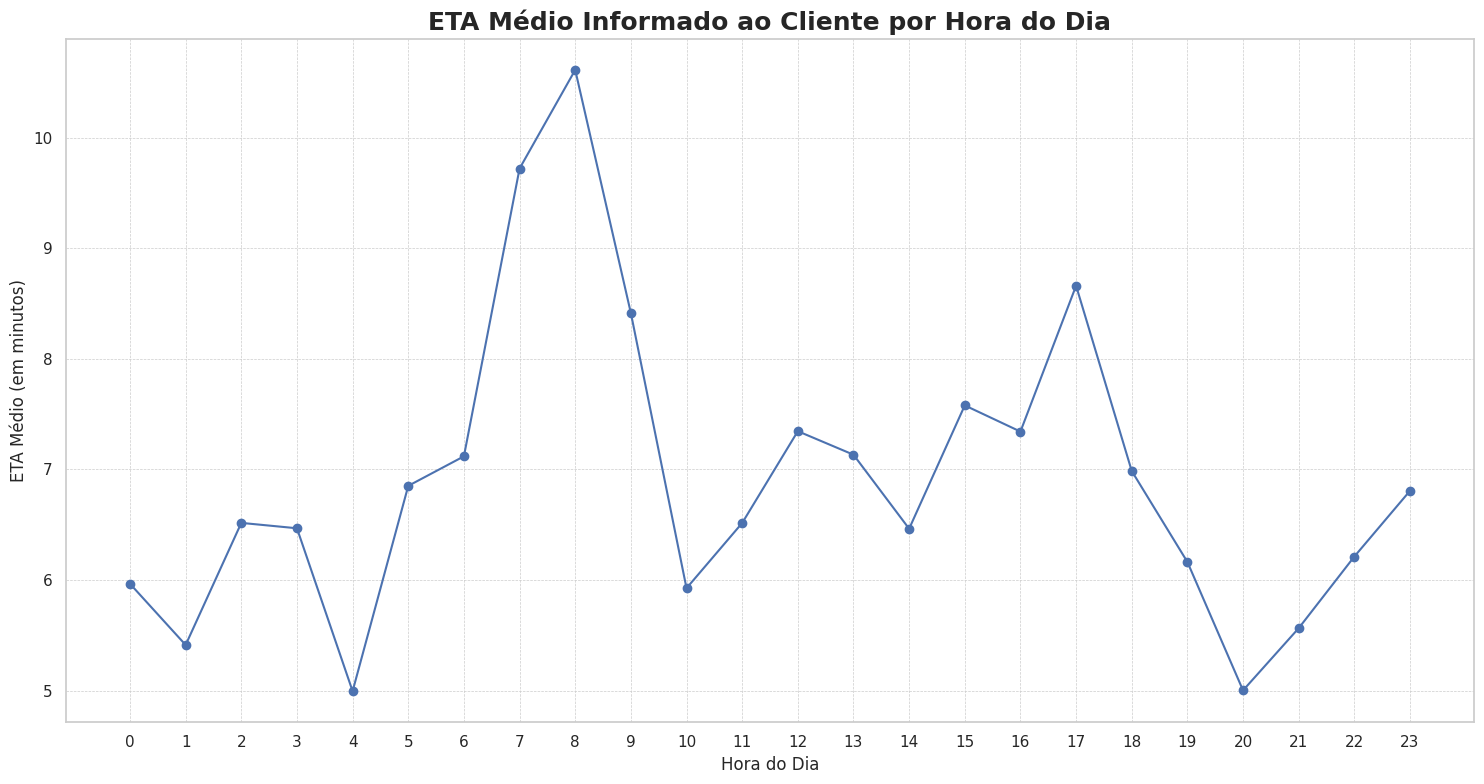

In [44]:
# --- Certifique-se de que seu dataframe 'df_orders' processado está carregado ---
# df_orders = pd.read_csv('data_orders_processed.csv')

# 1. Criar um dataframe temporário removendo as linhas onde o ETA é nulo
eta_data = df_orders.dropna(subset=['m_order_eta']).copy()

# 2. Calcular a média do ETA por hora
# A coluna ETA está em segundos, então vamos converter para minutos para melhor interpretação
eta_data['m_order_eta_minutes'] = eta_data['m_order_eta'] / 60
avg_eta_by_hour = eta_data.groupby('order_hour')['m_order_eta_minutes'].mean()

# 3. Plotar os resultados
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

ax = avg_eta_by_hour.plot(kind='line', marker='o', linestyle='-')

# 4. Adicionar títulos e rótulos
ax.set_title('ETA Médio Informado ao Cliente por Hora do Dia', fontsize=18, weight='bold')
ax.set_xlabel('Hora do Dia', fontsize=12)
ax.set_ylabel('ETA Médio (em minutos)', fontsize=12)
ax.set_xticks(range(0, 24))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Otimizar e salvar
plt.tight_layout()
plt.savefig('average_eta_by_hour.png')

print("Gráfico 'average_eta_by_hour.png' salvo com sucesso!")

# Identificando a hora com o maior ETA
peak_eta_hour = avg_eta_by_hour.idxmax()
peak_eta_value = avg_eta_by_hour.max()

print(f"\nA hora com o maior ETA médio é {peak_eta_hour}:00, com um tempo de espera de {peak_eta_value:.1f} minutos.")

O Problema Principal (O quê?): Nossa maior fonte de perda de clientes não são motoristas ruins ou problemas no aplicativo, mas sim a impaciência do cliente durante a busca inicial. Mais de 40% das falhas são de clientes que cancelam antes mesmo de um motorista ser designado.

O Ponto Crítico (Quando?): Este problema atinge seu pico absoluto às 8h da manhã. Neste horário, o volume de falhas dispara, sobrecarregando o sistema.

A Causa Raiz (Por quê?): O pico das 8h é causado por uma tempestade perfeita:

Condições de Mercado: O trânsito da cidade está no seu pior momento, o que eleva o ETA médio para mais de 10 minutos.

Comportamento do Cliente: Sabemos que a paciência do cliente sem motorista é, em média, de apenas 98 segundos (~1.6 minutos). Um ETA de 10 minutos é uma barreira quase intransponível para essa paciência. O resultado é um número massivo de cancelamentos e falhas no sistema.

Recomendação Estratégica: A Gett deve focar seus recursos em mitigar o impacto do horário de pico das 8h. A solução não é apenas ter mais motoristas, mas gerenciar as expectativas dos clientes e otimizar a eficiência da frota em condições de trânsito intenso.